In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_predict
from sklearn.inspection import permutation_importance
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit


In [3]:
# Load data
df = pd.read_csv("library_occupancy_MS3.csv")

# Parse Date (already in YYYY-MM-DD format)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop NA rows 
df = df.dropna(subset=['Date', 'Hour', 'DayOfWeek']).reset_index(drop=True)

# Sanity checks
print("Rows:", len(df))
print("Prelim flagged:", df['IsPrelimDay'].sum())
print("Day-before flagged:", df['IsPrelimMinus1'].sum())
print(df[['Date','IsPrelimDay','IsPrelimMinus1']].drop_duplicates().sort_values('Date').head(15))


Rows: 297
Prelim flagged: 91
Day-before flagged: 93
         Date  IsPrelimDay  IsPrelimMinus1
0  2025-10-05            0               0
3  2025-10-06            0               1
8  2025-10-07            1               0
12 2025-10-08            0               1
16 2025-10-09            1               0
19 2025-10-10            0               0
22 2025-10-11            0               0
27 2025-10-12            0               0
30 2025-10-13            0               0
33 2025-10-14            0               0
38 2025-10-15            0               1
42 2025-10-16            1               0
46 2025-10-17            0               0
49 2025-10-18            0               0
53 2025-10-19            0               0


In [4]:
# Hours helper
def in_range(h, start, end):
    """Return True if hour h is within [start, end) in 24h format."""
    return (h >= start) and (h < end)

# IsClosed per library 
# These are used to determine whether a given 
# library was closed on the day and time collected.

def is_closed_olin(row):
    h, d = row['Hour'], row['DayOfWeek']
    if d in ['Monday','Tuesday','Wednesday','Thursday']: return 0 if in_range(h, 8, 24) else 1
    if d == 'Friday': return 0 if in_range(h, 8, 18) else 1
    if d == 'Saturday': return 0 if in_range(h, 10, 18) else 1
    if d == 'Sunday': return 0 if in_range(h, 10, 24) else 1
    return 1

def is_closed_uris(row):
    h, d = row['Hour'], row['DayOfWeek']
    if d in ['Monday','Tuesday','Wednesday','Thursday']: return 0 if in_range(h, 8, 23) else 1
    if d == 'Friday': return 0 if in_range(h, 8, 17) else 1
    if d == 'Saturday': return 0 if in_range(h, 12, 17) else 1
    if d == 'Sunday': return 0 if in_range(h, 12, 23) else 1
    return 1

def is_closed_mann(row):
    h, d = row['Hour'], row['DayOfWeek']
    if d in ['Monday','Tuesday','Wednesday','Thursday']: return 0 if in_range(h, 8, 22) else 1
    if d == 'Friday': return 0 if in_range(h, 8, 18) else 1
    if d == 'Saturday': return 0 if in_range(h, 12, 18) else 1
    if d == 'Sunday': return 0 if in_range(h, 12, 22) else 1
    return 1

def is_closed_math(row):
    h, d = row['Hour'], row['DayOfWeek']
    if d in ['Saturday', 'Sunday']:
        return 1
    return 0 if in_range(h, 9, 16) else 1

df['IsClosed_Olin'] = df.apply(is_closed_olin, axis=1)
df['IsClosed_Uris'] = df.apply(is_closed_uris, axis=1)
df['IsClosed_Mann'] = df.apply(is_closed_mann, axis=1)
df['IsClosed_Math'] = df.apply(is_closed_math, axis=1)

# Drop rows if anything essential failed to parse
req = ['Hour','DayOfWeek_num','IsClosed_Olin','IsClosed_Uris',
       'IsClosed_Mann','IsClosed_Math']
df = df.dropna(subset=req).reset_index(drop=True)


,Library,RF R² (Baseline: Hour+DoW),RF R² (IsClosed+Prelim)
0,Olin,0.798,0.811
1,Uris,0.563,0.591
2,Mann,0.840,0.853
3,Math,0.329,0.340


interactive(children=(Dropdown(description='lib', options=('Olin', 'Uris', 'Mann', 'Math'), value='Olin'), Out…

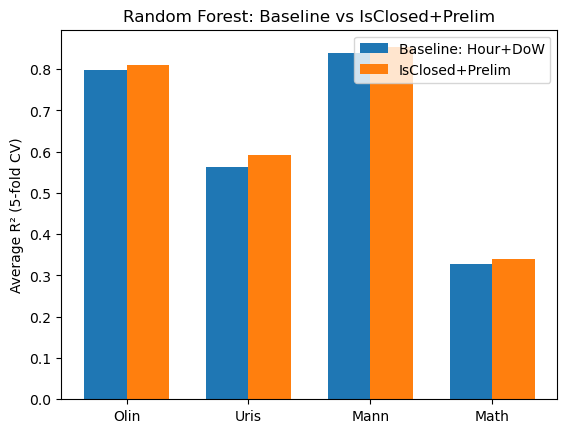

In [5]:
# Same CV for both models (Random Forest)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

libraries = ['Olin','Uris','Mann','Math']
for lib in libraries:
    # Baseline features
    X_base = df[['Hour','DayOfWeek_num']]

    # "With" features (Adding closing hours, and whether the data 
    # point falls on a prelim day, or a day before a prelim)
    X_with = df[['Hour','DayOfWeek_num', f'IsClosed_{lib}', 'IsPrelimDay', 'IsPrelimMinus1']]

    y = df[lib]

    rf = RandomForestRegressor(n_estimators=100, random_state=42)

    rf_base = cross_val_score(rf, X_base, y, scoring='r2', cv=cv).mean()
    rf_with = cross_val_score(rf, X_with, y, scoring='r2', cv=cv).mean()

    results.append({
        'Library': lib,
        'RF R² (Baseline: Hour+DoW)': rf_base,
        'RF R² (IsClosed+Prelim)': rf_with
    })

compare_df = pd.DataFrame(results).round(3)
display(compare_df)

@interact(lib=libraries)
def plot_hour_profile(lib):
    # group by hours, and library
    df["HourInt"] = df["Hour"].round().astype(int)
    hour_mean = df.groupby('HourInt')[lib].mean()

    plt.figure(figsize=(14, 5))
    plt.plot(hour_mean.index, hour_mean.values, marker='o')
    plt.title(f'Average occupancy by hour - {lib}')
    plt.xlabel('Hour of day')
    plt.ylabel('Average occupancy')
    plt.xticks(range(0, 24, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot 
plt.figure()
w = 0.35
x = np.arange(len(compare_df))
plt.bar(x - w/2, compare_df['RF R² (Baseline: Hour+DoW)'], width=w, label='Baseline: Hour+DoW')
plt.bar(x + w/2, compare_df['RF R² (IsClosed+Prelim)'], width=w, label='IsClosed+Prelim')
plt.xticks(x, compare_df['Library'])
plt.ylabel('Average R² (5-fold CV)')
plt.title('Random Forest: Baseline vs IsClosed+Prelim')
plt.legend()
plt.show()


In [6]:
# MAE via Cross Validation (Random Forest)

mae_rows = []
for lib in libraries:
    X_lib = df[['Hour', 'DayOfWeek_num', f'IsClosed_{lib}', 'IsPrelimDay', 'IsPrelimMinus1']]
    y_lib = df[lib]

    rf = RandomForestRegressor(n_estimators=100, random_state=42)

    maes = []
    for train_idx, test_idx in cv.split(X_lib):
        rf.fit(X_lib.iloc[train_idx], y_lib.iloc[train_idx])
        preds = rf.predict(X_lib.iloc[test_idx])
        maes.append(mean_absolute_error(y_lib.iloc[test_idx], preds))

    mae_rows.append({'Library': lib, 'RF MAE (with added features)': np.mean(maes)})

mae_df = pd.DataFrame(mae_rows).round(2)
mae_df

,Library,RF MAE (with added features)
0,Olin,67.32
1,Uris,46.70
2,Mann,28.45
3,Math,26.25


In [7]:
# Date-based Cross-Validation (GroupKFold by calendar day)

# Regular K-Fold mixes rows from the same day into both train/test,
# which makes the task easier (the model sees very similar contexts).
# GroupKFold holds out *entire days* at a time. This better tests
# generalization to unseen days.
#
# RF performance usually drops under Date-CV (harder problem).

gcv = GroupKFold(n_splits=5)
groups = df['Date'].dt.normalize()  # group by whole calendar day

def cv_r2_table(group_cv, groups):
    rows = []
    for lib in libraries:
        # Features: hour, DOW, is-closed, prelim day, day-before
        X = df[['Hour','DayOfWeek_num', f'IsClosed_{lib}', 'IsPrelimDay', 'IsPrelimMinus1']]
        y = df[lib]

        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_scores = cross_val_score(rf, X, y, scoring='r2', cv=group_cv, groups=groups)

        rows.append({
            'Library': lib,
            'RF R² (Date-CV, IsClosed+Prelim)': rf_scores.mean()
        })
    return pd.DataFrame(rows).round(3)

# Sanity check: need at least 5 unique days
# print("Unique days:", groups.nunique())

results_datecv_df = cv_r2_table(gcv, groups)
display(results_datecv_df)


,Library,"RF R² (Date-CV, IsClosed+Prelim)"
0,Olin,0.796
1,Uris,0.644
2,Mann,0.847
3,Math,0.422


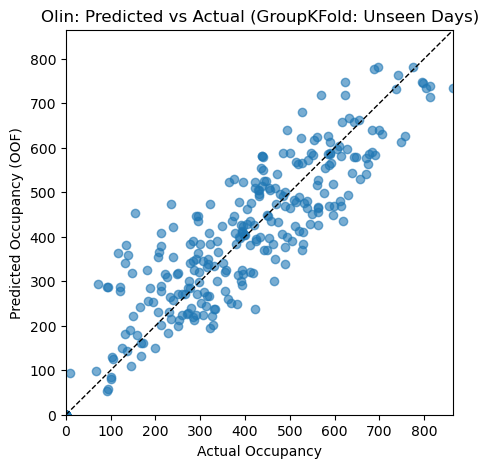

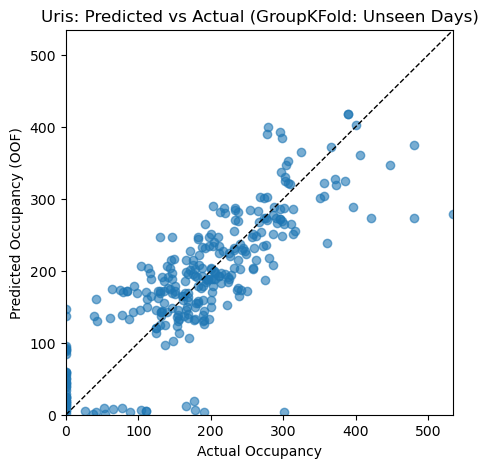

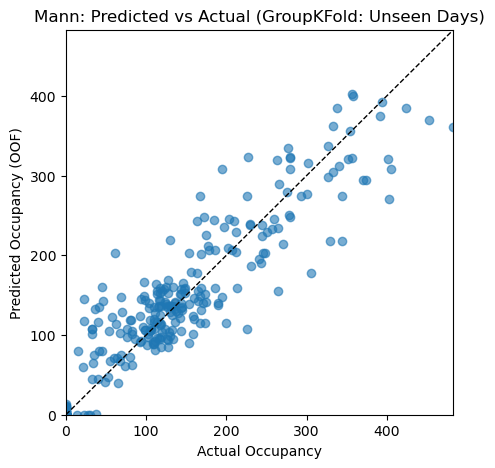

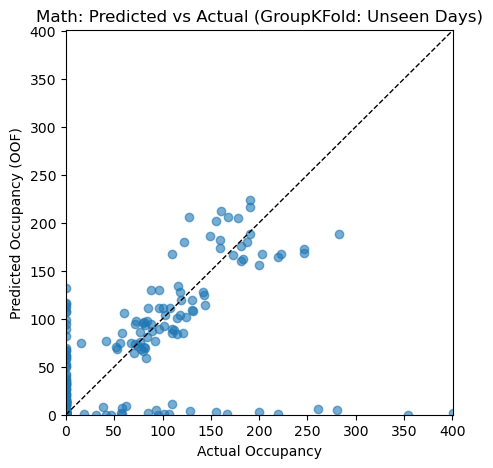

In [8]:
# Predicted vs Actual (Date-Based CV / GroupKFold)
# This shows how well the model generalizes to *unseen days*,
# meaning it tests the model's ability to predict when it has
# NOT seen any data from that date before.


for lib in libraries:
    # Features used in the model
    X = df[['Hour','DayOfWeek_num', f'IsClosed_{lib}', 'IsPrelimDay', 'IsPrelimMinus1']]
    y = df[lib]
    
    # Model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)

    # Out-of-fold predictions (each prediction is made from a model that has NOT seen that day)
    y_pred_oof = cross_val_predict(rf, X, y, cv=gcv, groups=groups)

    # Plot Actual vs Predicted
    plt.figure(figsize=(5,5))
    plt.scatter(y, y_pred_oof, alpha=0.6)
    
    # 45° reference line (perfect predictions)
    lims = [min(y.min(), y_pred_oof.min()), max(y.max(), y_pred_oof.max())]
    plt.plot(lims, lims, 'k--', linewidth=1)
    plt.xlim(lims); plt.ylim(lims)
    
    plt.xlabel("Actual Occupancy")
    plt.ylabel("Predicted Occupancy (OOF)")
    plt.title(f"{lib}: Predicted vs Actual (GroupKFold: Unseen Days)")
    plt.show()



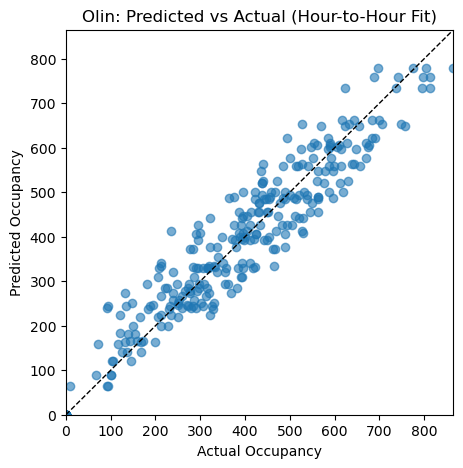

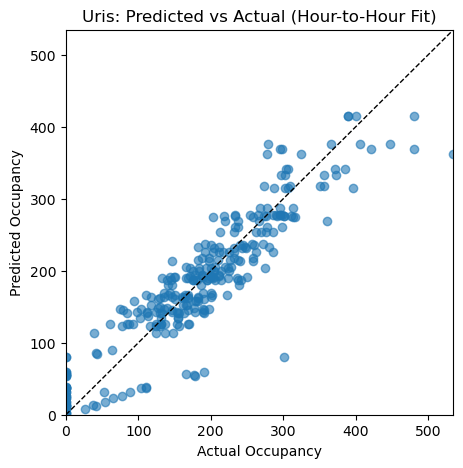

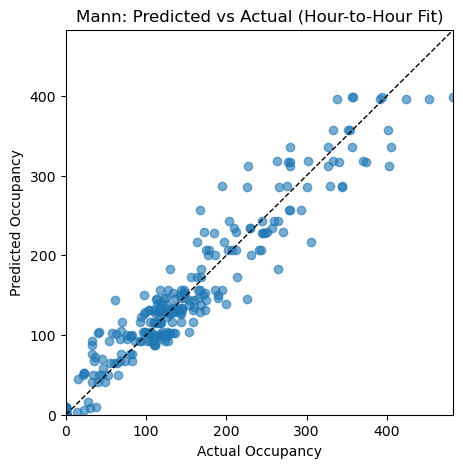

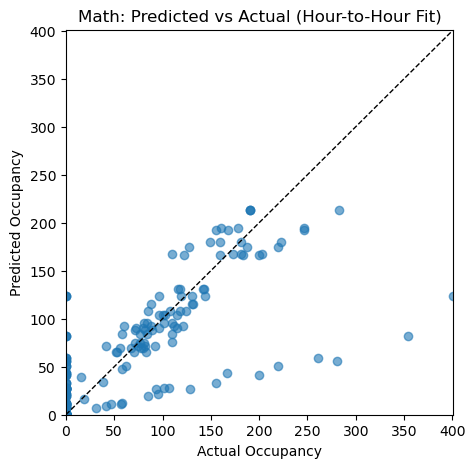

In [9]:
# Predicted vs Actual (Hour-to-Hour Fit on Training Data)
# This shows how well the model matches *patterns observed
# within the same days it was trained on*. This is NOT a
# generalization test — it reflects how closely the model
# learns the typical daily occupancy curve.
# Useful for understanding whether the model captures
# intraday shape (rush hours, slow periods, etc.).

for lib in libraries:

    # Features used in the hour-level model
    X = df[['Hour', 'DayOfWeek_num', f'IsClosed_{lib}', 'IsPrelimDay', 'IsPrelimMinus1']]
    y = df[lib]

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)

    preds = rf.predict(X)

    # Plot 
    plt.figure(figsize=(5,5))
    plt.scatter(y, preds, alpha=0.6)

    # 45° line 
    lims = [min(y.min(), preds.min()), max(y.max(), preds.max())]
    plt.plot(lims, lims, 'k--', linewidth=1)
    plt.xlim(lims); plt.ylim(lims)

    plt.xlabel("Actual Occupancy")
    plt.ylabel("Predicted Occupancy")
    plt.title(f"{lib}: Predicted vs Actual (Hour-to-Hour Fit)")
    plt.show()


In [10]:

# Feature Importance (Random Forest)
# This shows which features contribute most to the model's
# occupancy predictions. 
# This helps us identify what the model is actually *using*:
# - Hour + DayOfWeek should dominate (daily usage pattern)
# - IsClosed should matter heavily when libraries are closed
# - Prelim features may impact spikes (but limited dataset)

for lib in libraries:

    # Feature set for this library
    X = df[['Hour', 'DayOfWeek_num', f'IsClosed_{lib}', 'IsPrelimDay', 'IsPrelimMinus1']]
    y = df[lib]

    # Train Random Forest for feature importance extraction
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)

    # Create sorted importance table
    importance = (
        pd.Series(rf.feature_importances_, index=X.columns)
        .sort_values(ascending=False)
        .rename("Importance")
        .round(3)
    )

    print(f"Feature Importance for {lib} Library:")
    display(importance.to_frame())  # cleaner table format



Feature Importance for Olin Library:


,Importance
DayOfWeek_num,0.520
Hour,0.445
IsPrelimDay,0.019
IsPrelimMinus1,0.015
IsClosed_Olin,0.001


Feature Importance for Uris Library:


,Importance
IsClosed_Uris,0.461
Hour,0.426
DayOfWeek_num,0.067
IsPrelimMinus1,0.031
IsPrelimDay,0.015


Feature Importance for Mann Library:


,Importance
Hour,0.434
IsClosed_Mann,0.400
DayOfWeek_num,0.109
IsPrelimMinus1,0.030
IsPrelimDay,0.027


Feature Importance for Math Library:


,Importance
IsClosed_Math,0.605
Hour,0.317
DayOfWeek_num,0.042
IsPrelimMinus1,0.019
IsPrelimDay,0.017


In [11]:
# Comparison + MAE summary
results_df = pd.DataFrame(results)

mae_df_fixed = mae_df.rename(columns={
    'RF MAE (with added features)': 'RF MAE'
})

summary_df = (
    results_df.merge(mae_df_fixed, on='Library', how='inner')
              [['Library',
                'RF R² (Baseline: Hour+DoW)',
                'RF R² (IsClosed+Prelim)',
                'RF MAE']]
              .round(3)
)

display(summary_df)

,Library,RF R² (Baseline: Hour+DoW),RF R² (IsClosed+Prelim),RF MAE
0,Olin,0.798,0.811,67.32
1,Uris,0.563,0.591,46.70
2,Mann,0.840,0.853,28.45
3,Math,0.329,0.340,26.25


In [12]:
# Permutation Importance (Evaluated on Unseen Days)
# This tells us which features matter *when predicting a new day we haven't seen before*.

for lib in libraries:
    # Features used in the model
    X = df[['Hour','DayOfWeek_num', f'IsClosed_{lib}', 'IsPrelimDay', 'IsPrelimMinus1']]
    y = df[lib]
    
    rf = RandomForestRegressor(n_estimators=100, random_state=42)

    # Train only on some days, test on the held-out days (no leakage)
    train_idx, test_idx = next(gcv.split(X, y, groups=groups))
    rf.fit(X.iloc[train_idx], y.iloc[train_idx])

    # Measure how much each feature changes model performance when shuffled
    perm = permutation_importance(
        rf, X.iloc[test_idx], y.iloc[test_idx],
        n_repeats=20, random_state=42
    )

    importance = (
        pd.Series(perm.importances_mean, index=X.columns)
        .sort_values(ascending=False)
        .round(3)
    )

    print(f"\nPermutation Importance (Unseen Days) — {lib}")
    display(importance.to_frame(name="Importance"))



Permutation Importance (Unseen Days) — Olin


,Importance
Hour,0.924
DayOfWeek_num,0.503
IsPrelimMinus1,0.014
IsClosed_Olin,0.001
IsPrelimDay,-0.019



Permutation Importance (Unseen Days) — Uris


,Importance
Hour,0.773
IsClosed_Uris,0.108
IsPrelimMinus1,0.078
DayOfWeek_num,0.035
IsPrelimDay,-0.003



Permutation Importance (Unseen Days) — Mann


,Importance
Hour,0.911
IsClosed_Mann,0.282
DayOfWeek_num,0.109
IsPrelimMinus1,0.046
IsPrelimDay,0.003



Permutation Importance (Unseen Days) — Math


,Importance
IsClosed_Math,2.326
Hour,0.491
IsPrelimMinus1,-0.022
DayOfWeek_num,-0.025
IsPrelimDay,-0.043


In [13]:
# Train final models for the dashboard
lib_models = {}

for lib in libraries:
    X = df[['Hour', 'DayOfWeek_num', f'IsClosed_{lib}', 'IsPrelimDay', 'IsPrelimMinus1']]
    y = df[lib]

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    lib_models[lib] = rf

print("Trained dashboard models for:", list(lib_models.keys()))


Trained dashboard models for: ['Olin', 'Uris', 'Mann', 'Math']


In [15]:
# day-of-week mapping 
dow_map = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6,
}

# helper to compute whether the library is closed 
def compute_is_closed(lib, hour, dow_name):
    """
    lib: one of the library names in `libraries`
    hour: float, e.g. 12.75 for 12:45
    dow_name: string, e.g. 'Monday'
    """
    row = pd.Series({'Hour': hour, 'DayOfWeek': dow_name})

    if lib == 'Olin':
        return is_closed_olin(row)
    elif lib == 'Uris':
        return is_closed_uris(row)
    elif lib == 'Mann':
        return is_closed_mann(row)
    elif lib == 'Math':
        return is_closed_math(row)
    else:
        return 1  


# dashboard widgets 
lib_dd = widgets.Dropdown(
    options=libraries,
    value=libraries[0],
    description='Library:'
)

date_picker = widgets.DatePicker(
    description='Date:',
    disabled=False
)

hour_slider = widgets.IntSlider(
    value=12,
    min=0,
    max=23,
    step=1,
    description='Hour:'
)

minute_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=59,
    step=1,
    description='Minute:'
)

output = widgets.Output()


# Main update function 
def update_dashboard(change=None):
    with output:
        output.clear_output()

        lib = lib_dd.value

    
        if date_picker.value is not None:
            date_val = pd.to_datetime(date_picker.value)
            dow_name = date_val.day_name() 
        else:
            dow_name = 'Monday' 

        dow_num = dow_map[dow_name]

        # Time
        hour = hour_slider.value
        minute = minute_slider.value
        hour_decimal = hour + minute / 60.0  

        # Closed flag from schedule 
        is_closed = compute_is_closed(lib, hour_decimal, dow_name)

        # Feature row for the model
        X_new = pd.DataFrame([{
            'Hour': hour_decimal,
            'DayOfWeek_num': dow_num,
            f'IsClosed_{lib}': is_closed,
            'IsPrelimDay': 0,
            'IsPrelimMinus1': 0,
        }])

        X_new_model = X_new[['Hour', 'DayOfWeek_num', f'IsClosed_{lib}', 'IsPrelimDay', 'IsPrelimMinus1']]

        model = lib_models[lib]
        pred = model.predict(X_new_model)[0]
        pred_int = int(round(pred))

        mask = (df['DayOfWeek_num'] == dow_num) & (df['Hour'] == hour)
        hist_mean = df.loc[mask, lib].mean()

        time_str = f"{hour:02d}:{minute:02d}"

        print(f"{lib} — {dow_name} at {time_str}")
        print()

        if is_closed == 1:
            print("The library is closed at this time!")
        else:
            print(f"Predicted Population: {pred_int}")
            
            

# Hook up events
for w in [lib_dd, date_picker, hour_slider, minute_slider]:
    w.observe(update_dashboard, names='value')

controls = widgets.HBox([lib_dd, date_picker, hour_slider, minute_slider])
dashboard = widgets.VBox([controls, output])

display(dashboard)
update_dashboard()
